Matt Dwyer

Written for Python 3

This notebook explores NYC historical crime data through a time series analysis, K Means clustering of crime in NYC precincts both temporally and spatially, and the creation of a function that uses a multi variate regression model to measure the relationship between socioeconomic features and a given input crime type.

In [617]:
import numpy as np
import pandas as pd
import pylab as pl
from sklearn import cluster
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import geopandas as gpd
import os
import urllib
from urllib.request import urlopen
from io import StringIO
import io
import ast
import statsmodels.formula.api as smf
import scipy.stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. Time domain exploratory analysis of crime

## 1.1 obtain historical data for 2000-2016 for all NYC police precincts


In [618]:
crime = pd.read_excel("https://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/seven-major-felony-offenses-by-precinct-2000-2016.xls"\
                     , header=2)

In [619]:
# Filling blank values in PCT with precinct number based on value above
crime['PCT'] = crime['PCT'].fillna(method='ffill')
crime.head(3)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,RAPE,12.0,5.0,10.0,11.0,11.0,5.0,4.0,7.0,12.0,4.0,6.0,13.0,10.0,12.0,8.0,7.0,9.0
2,1,ROBBERY,252.0,188.0,210.0,164.0,154.0,172.0,119.0,128.0,108.0,106.0,96.0,102.0,81.0,68.0,50.0,79.0,60.0


## 1.2 remove outliers 

In [620]:
# remove rows that are not for a precinct (all precincts are identified by numbers)
crime = crime[0:616]
crime.tail(3)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
613,123,GRAND LARCENY,101.0,90.0,116.0,137.0,166.0,233.0,175.0,181.0,191.0,171.0,147.0,175.0,183.0,171.0,194.0,163.0,145.0
614,123,GRAND LARCENY OF MOTOR VEHICLE ...,266.0,193.0,143.0,131.0,95.0,96.0,114.0,87.0,81.0,51.0,39.0,48.0,31.0,40.0,30.0,20.0,23.0
615,123,TOTAL SEVEN MAJOR FELONY OFFENSES,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,378.0,348.0,302.0


Other than incorrect values of the NaNs and text about statistics descriptions, no outliers were found. 

## 1.3  Plot the time series for each of the seven major felonies and for the total (aggregation of all felonies). 

In [621]:
# Grouping each precinct by crime type, changing datatype of columns
felonies = pd.concat([crime.iloc[:,[1,2]].groupby('CRIME').sum(),crime.iloc[:,[1,3]].groupby('CRIME').sum(),
          crime.iloc[:,[1,4]].groupby('CRIME').sum(),crime.iloc[:,[1,5]].groupby('CRIME').sum(),
          crime.iloc[:,[1,6]].groupby('CRIME').sum(),crime.iloc[:,[1,7]].groupby('CRIME').sum(),
          crime.iloc[:,[1,8]].groupby('CRIME').sum(),crime.iloc[:,[1,9]].groupby('CRIME').sum(),
          crime.iloc[:,[1,10]].groupby('CRIME').sum(),crime.iloc[:,[1,11]].groupby('CRIME').sum(),
          crime.iloc[:,[1,12]].groupby('CRIME').sum(),crime.iloc[:,[1,13]].groupby('CRIME').sum(),
          crime.iloc[:,[1,14]].groupby('CRIME').sum(),crime.iloc[:,[1,15]].groupby('CRIME').sum(),
          crime.iloc[:,[1,16]].groupby('CRIME').sum(),crime.iloc[:,[1,17]].groupby('CRIME').sum(),
          crime.iloc[:,[1,18]].groupby('CRIME').sum()],axis=1)

felonies.columns = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,\
                                 2011, 2012, 2013, 2014, 2015, 2016]
felonies

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
CRIME,,,,,,,,,,,,,,,,,
BURGLARY,38352.0,32763.0,31275.0,29110.0,26976.0,24117.0,23143.0,21762.0,20725.0,19430.0,18600.0,18720.0,19211.0,17429.0,16765.0,15125.0,12990.0
FELONY ASSAULT,25924.0,23453.0,21147.0,19139.0,18622.0,17750.0,17309.0,17493.0,16284.0,16773.0,16956.0,18482.0,19452.0,20297.0,19805.0,19896.0,20346.0
GRAND LARCENY,49631.0,46329.0,45771.0,46751.0,48763.0,48243.0,46625.0,44924.0,44242.0,39580.0,37835.0,38501.0,42699.0,45368.0,43857.0,44004.0,44273.0
GRAND LARCENY OF MOTOR VEHICLE,35442.0,29531.0,26656.0,23413.0,20884.0,18246.0,15745.0,13174.0,12482.0,10670.0,10329.0,9314.0,8082.0,7400.0,7664.0,7332.0,6327.0
MURDER & NON NEGL. MANSLAUGHTER,673.0,649.0,587.0,597.0,570.0,539.0,596.0,496.0,523.0,471.0,536.0,515.0,419.0,335.0,333.0,352.0,335.0
RAPE,2068.0,1981.0,2144.0,2070.0,1905.0,1858.0,1525.0,1351.0,1299.0,1205.0,1373.0,1420.0,1450.0,1378.0,1352.0,1435.0,1436.0
ROBBERY,32562.0,28202.0,27229.0,25989.0,24373.0,24722.0,23739.0,21809.0,22401.0,18601.0,19486.0,19717.0,20175.0,19128.0,16533.0,16930.0,15500.0
TOTAL SEVEN MAJOR FELONY OFFENSES,184652.0,162908.0,154809.0,147069.0,142093.0,135475.0,128682.0,121009.0,117956.0,106730.0,105115.0,106669.0,111488.0,111335.0,106309.0,105074.0,101207.0


In [622]:
# removing spaces from crime type names
felonies = felonies.rename(index={'BURGLARY                              ': 'BURGLARY',
                                  'FELONY ASSAULT                        ': 'FELONT ASSAULT',
                                  'GRAND LARCENY                         ': 'GRAND LARCENY',
        'GRAND LARCENY OF MOTOR VEHICLE                                  ': 'GRAND LARCENY OF MOTOR VEHICLE',
         'MURDER & NON NEGL. MANSLAUGHTER                                ': 'MURDER & NON NEGL. MANSLAUGHTER',
                                  'RAPE                                  ': 'RAPE',
                                  'ROBBERY                               ': 'ROBBERY',
                                       'TOTAL SEVEN MAJOR FELONY OFFENSES': 'TOTAL SEVEN MAJOR FELONY OFFENSES'})
felonies.index

Index(['BURGLARY', 'FELONT ASSAULT', 'GRAND LARCENY',
       'GRAND LARCENY OF MOTOR VEHICLE', 'MURDER & NON NEGL. MANSLAUGHTER',
       'RAPE', 'ROBBERY', 'TOTAL SEVEN MAJOR FELONY OFFENSES'],
      dtype='object', name='CRIME')

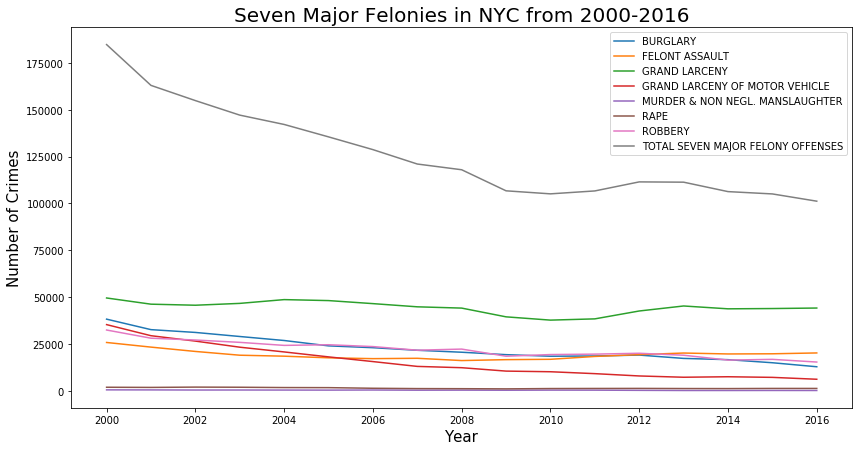

In [623]:
plt.figure(figsize=(14,7))
plt.plot(felonies.T)
plt.legend(felonies.T.columns)
plt.title("Seven Major Felonies in NYC from 2000-2016",fontsize=20)
plt.xlabel("Year",fontsize=15)
plt.ylabel("Number of Crimes",fontsize=15)
plt.show()

Figure 1. The time series for the seven major felonies from 2000 to 2016, summed by each NYC precinct. Each type of crime shows a slow decrease over time, while the total felony line illustrates the overall steeper decrease. 

## 1.4 calculate the mean and standard deviation in time for each precinct and each crime

In [624]:
crime.columns

Index([  'PCT', 'CRIME',    2000,    2001,    2002,    2003,    2004,    2005,
        '2006',  '2007',  '2008',  '2009',    2010,  '2011',    2012,    2013,
          2014,    2015,    2016],
      dtype='object')

In [625]:
crime['crimeMean'] = crime[[2000, 2001, 2002, 2003, 2004, 2005,'2006','2007','2008','2009', 
                            2010,'2011', 2012,2013,2014,2015,2016]].mean(axis=1)
crime['crimeStDev'] = crime[[2000, 2001, 2002, 2003, 2004, 2005,'2006','2007','2008','2009', 
                            2010,'2011', 2012,2013,2014,2015,2016]].std(axis=1)
crime.head()

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,...,2009,2010,2011,2012,2013,2014,2015,2016,crimeMean,crimeStDev
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,...,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.058824,0.966345
1,1,RAPE,12.0,5.0,10.0,11.0,11.0,5.0,4.0,7.0,...,4.0,6.0,13.0,10.0,12.0,8.0,7.0,9.0,8.588235,3.063063
2,1,ROBBERY,252.0,188.0,210.0,164.0,154.0,172.0,119.0,128.0,...,106.0,96.0,102.0,81.0,68.0,50.0,79.0,60.0,125.705882,56.514118
3,1,FELONY ASSAULT,139.0,164.0,147.0,134.0,129.0,121.0,94.0,90.0,...,83.0,68.0,94.0,110.0,87.0,76.0,86.0,78.0,104.882353,28.676825
4,1,BURGLARY,475.0,437.0,297.0,403.0,246.0,293.0,255.0,231.0,...,207.0,170.0,155.0,188.0,171.0,145.0,138.0,117.0,242.176471,107.459431


In [626]:
precincts = crime[['PCT','CRIME','crimeMean','crimeStDev']].pivot(index = 'CRIME',columns='PCT')
precincts

crimeMean               \
PCT                                                         1            5     
CRIME                                                                          
BURGLARY                                             242.176471   152.941176   
FELONY ASSAULT                                       104.882353   130.941176   
GRAND LARCENY                                       1406.705882   616.823529   
GRAND LARCENY OF MOTOR VEHICLE                 ...    81.470588    45.882353   
MURDER & NON NEGL. MANSLAUGHTER                ...     1.058824     1.882353   
RAPE                                                   8.588235     7.529412   
ROBBERY                                              125.705882   147.058824   
TOTAL SEVEN MAJOR FELONY OFFENSES                   1970.588235  1103.058824   

                                                                             \
PCT                                                         6           7     
CRIME                                                                         
BURGLARY                                             225.588235  108.176471   
FELONY ASSAULT                                       114.352941  124.411765   
GRAND LARCENY                                       1183.000000  317.352941   
GRAND LARCENY OF MOTOR VEHICLE                 ...    82.117647   74.117647   
MURDER & NON NEGL. MANSLAUGHTER                ...     1.294118    2.588235   
RAPE                                                   9.470588   10.705882   
ROBBERY                                              199.823529  172.000000   
TOTAL SEVEN MAJOR FELONY OFFENSES                   1815.647059  809.352941   

                                                                              \
PCT                                                         9            10    
CRIME                                                                          
BURGLARY                                             247.882353   128.058824   
FELONY ASSAULT                                       169.647059   120.647059   
GRAND LARCENY                                        833.176471   699.764706   
GRAND LARCENY OF MOTOR VEHICLE                 ...    89.529412    78.058824   
MURDER & NON NEGL. MANSLAUGHTER                ...     2.294118     2.176471   
RAPE                                                  15.470588    10.470588   
ROBBERY                                              208.764706   142.411765   
TOTAL SEVEN MAJOR FELONY OFFENSES                   1566.764706  1181.588235   

                                                                              \
PCT                                                         13           14    
CRIME                                                                          
BURGLARY                                             367.941176   514.764706   
FELONY ASSAULT                                       170.294118   215.882353   
GRAND LARCENY                                       1630.117647  2899.823529   
GRAND LARCENY OF MOTOR VEHICLE                 ...   107.294118    44.941176   
MURDER & NON NEGL. MANSLAUGHTER                ...     2.000000     2.705882   
RAPE                                                  14.470588    12.705882   
ROBBERY                                              233.941176   292.941176   
TOTAL SEVEN MAJOR FELONY OFFENSES                   2526.058824  3983.764706   

                                                                              \
PCT                                                         17           18    
CRIME                                                                          
BURGLARY                                             167.941176   311.176471   
FELONY ASSAULT                                        71.882353   168.352941   
GRAND LARCENY                                        932.235294  2406.941176   
GRAND LARCENY OF MOTOR VEHICLE                 ...    51.6470

The above precincts dataframe lists the mean and standard deviation of crimes in the timeline by each precinct and crime. 

## 1.5 extract the total crime row for each precinct and cluster the time series. Plot the clusters and discuss the clustering and the trends. 

In [627]:
totcrime = crime[crime['CRIME'].str.contains("TOTAL")]
totcrime = totcrime[[2000,2001,2002,2003,2004,2005,'2006','2007','2008',
                     '2009',2010,'2011',2012,2013,2014,2015,2016]]

totcrime.columns = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,\
                      2011, 2012, 2013, 2014, 2015, 2016]
totcrime = totcrime.dropna()

Replacing NaN values with means was considered, but instead were dropped instead of replaced, so as not to assume any values. 

In [628]:
totcrime.head(3)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
7,3438.0,3069.0,2715.0,2649.0,2383.0,2305.0,2013.0,1914.0,1708.0,1578.0,1445.0,1402.0,1416.0,1416.0,1208.0,1446.0,1395.0
15,1780.0,1458.0,1309.0,1231.0,1170.0,1131.0,1040.0,1031.0,1029.0,975.0,969.0,962.0,1001.0,980.0,870.0,917.0,899.0
23,2387.0,2141.0,2059.0,2068.0,2174.0,2055.0,1979.0,1837.0,1738.0,1633.0,1530.0,1504.0,1574.0,1703.0,1575.0,1521.0,1388.0


In [629]:
# Preprocessing the data
vals = ((totcrime.T - totcrime.mean(1)) / totcrime.std(1)).T

# expect mean to be 0
print(vals.mean(1)[:5])
#expect st dev to be 1
print(vals.std(1)[:5])

7     1.240837e-16
15    2.155139e-16
23   -3.004133e-16
31   -2.563309e-16
39    5.224579e-17
dtype: float64
7     1.0
15    1.0
23    1.0
31    1.0
39    1.0
dtype: float64


In [630]:
# KMeans clustering
nc = 4
km = KMeans(n_clusters=nc, random_state=444)
km.fit(vals)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=444, tol=0.0001,
    verbose=0)

In [631]:
vals['cluster'] = km.labels_

In [632]:
vals.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,cluster
7,2.174406,1.627623,1.103067,1.005268,0.611110,0.495530,0.062846,-0.083852,-0.389102,-0.581736,-0.778815,-0.842532,-0.821787,-0.821787,-1.130001,-0.777333,-0.852905,0
15,2.897487,1.519242,0.881483,0.547622,0.286526,0.119596,-0.269908,-0.308431,-0.316991,-0.548126,-0.573807,-0.603769,-0.436839,-0.526724,-0.997553,-0.796381,-0.873426,0
23,1.942063,1.105894,0.827171,0.857763,1.218063,0.813575,0.555247,0.072580,-0.263927,-0.620828,-0.970932,-1.059307,-0.821373,-0.382894,-0.817974,-1.001523,-1.453598,0
31,2.152564,0.984810,1.175464,0.651166,0.567755,-0.063785,0.651166,0.555840,-0.028037,-1.279202,-1.279202,-1.255370,-0.564251,-1.171959,-0.921726,-0.337850,0.162616,0
39,2.589303,0.497024,1.144072,1.106288,0.851247,0.459240,0.057787,-0.225592,-0.338943,-0.206700,-0.849025,-1.023775,-0.697889,-0.674275,-1.113512,-1.085174,-0.490078,0


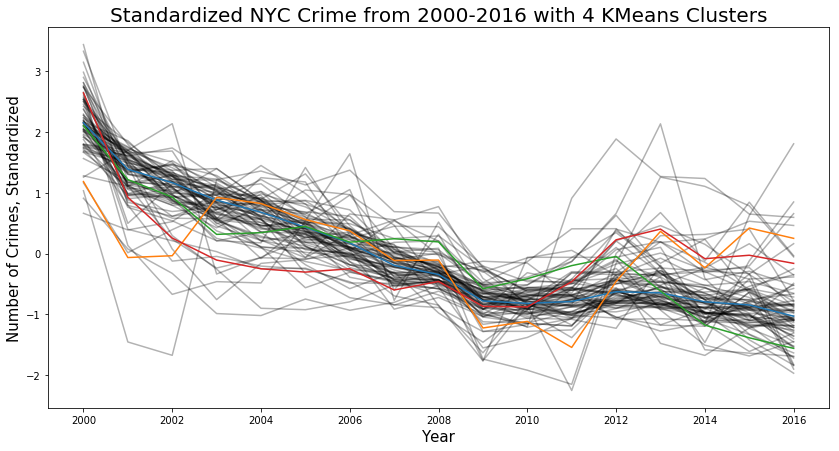

In [633]:
# Plotting all precincts with KMeans clusters
plt.figure(figsize=(14,7))
plt.plot(vals.iloc[:,0:17].T,'k-',alpha=0.3)
plt.plot(vals[km.labels_ == 0].iloc[:,:-1].mean().T)
plt.plot(vals[km.labels_ == 1].iloc[:,:-1].mean().T)
plt.plot(vals[km.labels_ == 2].iloc[:,:-1].mean().T)
plt.plot(vals[km.labels_ == 3].iloc[:,:-1].mean().T)
plt.ylabel("Number of Crimes, Standardized",fontsize=15)
plt.xlabel("Year",fontsize=15)
plt.title("Standardized NYC Crime from 2000-2016 with 4 KMeans Clusters",fontsize=20)
plt.show()

Figure 2. A time series showing each precinct, along with 4 KMeans clusters. The clusters are graphed by computing the mean of each cluster of precincts.

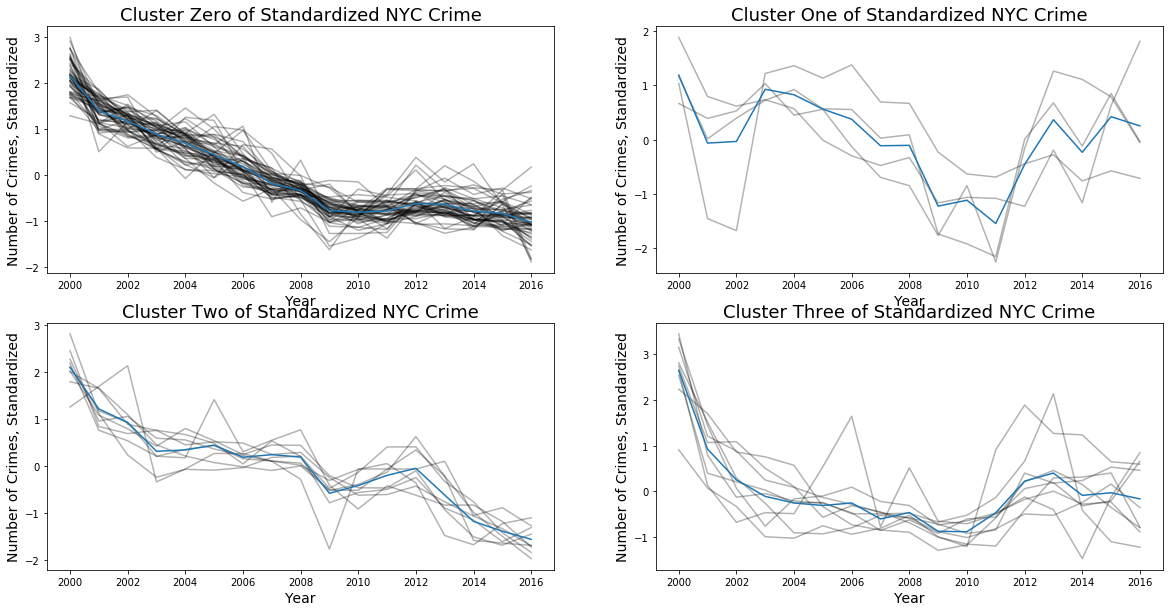

In [634]:
#plotting each cluster and calculating cluster center through mean
ax = plt.subplots(nrows=2, ncols=2,figsize=(20,10))

plt.subplot(2, 2, 1)
plt.plot(vals[km.labels_ == 0].iloc[:,0:17].T,'k-',alpha=0.3)
plt.plot(vals[km.labels_ == 0].iloc[:,:-1].mean().T)
plt.ylabel("Number of Crimes, Standardized",fontsize=14)
plt.xlabel("Year",fontsize=14)
plt.title("Cluster Zero of Standardized NYC Crime",fontsize=18)

plt.subplot(2, 2, 2)
plt.plot(vals[km.labels_ == 1].iloc[:,0:17].T,'k-',alpha=0.3)
plt.plot(vals[km.labels_ == 1].iloc[:,:-1].mean().T)
plt.ylabel("Number of Crimes, Standardized",fontsize=14)
plt.xlabel("Year",fontsize=14)
plt.title("Cluster One of Standardized NYC Crime",fontsize=18)

plt.subplot(2, 2, 3)
plt.plot(vals[km.labels_ == 2].iloc[:,0:17].T,'k-',alpha=0.3)
plt.plot(vals[km.labels_ == 2].iloc[:,:-1].mean().T)
plt.ylabel("Number of Crimes, Standardized",fontsize=14)
plt.xlabel("Year",fontsize=14)
plt.title("Cluster Two of Standardized NYC Crime",fontsize=18)

plt.subplot(2, 2, 4)
plt.plot(vals[km.labels_ == 3].iloc[:,0:17].T,'k-',alpha=0.3)
plt.plot(vals[km.labels_ == 3].iloc[:,:-1].mean().T)
plt.ylabel("Number of Crimes, Standardized",fontsize=14)
plt.xlabel("Year",fontsize=14)
plt.title("Cluster Three of Standardized NYC Crime",fontsize=18)

plt.show()

Figure 3. The same crime data with precincts by year as figure 2, but seperated by cluster group. The blue line indicates the center of each cluster.

Four clusters were chosen as each cluster is able to approximate several different trends within the data. The trends of each cluster outline the range of values that occur in the crime data. Cluster zero's shape apperas to cover the most precincts, and shows a gradual downward trend in crime. Cluster one however shows a different trend as  crime lowers around 2010, and then increases into 2016. Cluster two shows a similar trend to cluster zero, except covers different trends in peaks than zero's smoother decline. Cluster three covers a steep beginning decline in crime, while also accounting for some variability after 2010. 

# Part 2: connecting the temporal and spatial components.
## 2.1 obtain the NYC precincts geometry and read it in as a shapefile           

In [635]:
PUIDATA = os.getenv("PUIDATA")

In [636]:
url = "https://data.cityofnewyork.us/api/geospatial/78dh-3ptz?method=export&format=Shapefile"

urllib.request.urlretrieve(url, "pct.zip")

os.system("unzip -d %s pct.zip"%(os.getenv("PUIDATA")))

0

In [637]:
pctshp = gpd.GeoDataFrame.from_file((os.getenv("PUIDATA") + "/geo_export_2f186ff4-1e29-4c0a-ab89-0d10b1a4fb62.shp"))
pctshp.head()

,precinct,shape_leng,shape_area,geometry
0,1.0,80586.154615,4.730176e+07,(POLYGON ((-74.0438776157395 40.69018767637665...
1,5.0,18676.124259,1.808880e+07,POLYGON ((-73.98863862848766 40.72293372026369...
2,6.0,27182.610113,2.213193e+07,POLYGON ((-73.99968392160721 40.73855224865976...
3,7.0,17301.308682,1.836402e+07,"POLYGON ((-73.97345389423181 40.718962954076, ..."
4,9.0,19773.233410,2.139423e+07,POLYGON ((-73.97160900246391 40.72672340116989...


In [638]:
pctshp.crs

{'init': 'epsg:4326'}

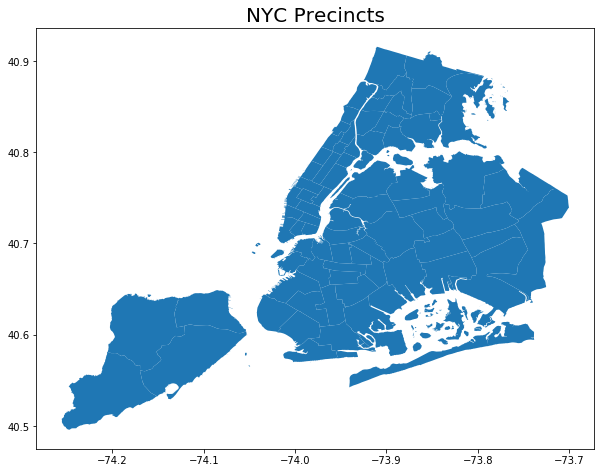

In [639]:
pctshp.plot(figsize=(10,10))
plt.title("NYC Precincts",fontsize=20)
plt.show()

Figure 4. The Precincts in NYC used by NYPD

## 2.2 merge the precincts geodataframe with the dataframe of crime that were used to cluster the time series and plot a choropleth of the clusters. 

In [640]:
pctvals = vals.merge(crime[['PCT']],left_index=True,right_index=True)
pctvals.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,cluster,PCT
7,2.174406,1.627623,1.103067,1.005268,0.611110,0.495530,0.062846,-0.083852,-0.389102,-0.581736,-0.778815,-0.842532,-0.821787,-0.821787,-1.130001,-0.777333,-0.852905,0,1
15,2.897487,1.519242,0.881483,0.547622,0.286526,0.119596,-0.269908,-0.308431,-0.316991,-0.548126,-0.573807,-0.603769,-0.436839,-0.526724,-0.997553,-0.796381,-0.873426,0,5
23,1.942063,1.105894,0.827171,0.857763,1.218063,0.813575,0.555247,0.072580,-0.263927,-0.620828,-0.970932,-1.059307,-0.821373,-0.382894,-0.817974,-1.001523,-1.453598,0,6
31,2.152564,0.984810,1.175464,0.651166,0.567755,-0.063785,0.651166,0.555840,-0.028037,-1.279202,-1.279202,-1.255370,-0.564251,-1.171959,-0.921726,-0.337850,0.162616,0,7
39,2.589303,0.497024,1.144072,1.106288,0.851247,0.459240,0.057787,-0.225592,-0.338943,-0.206700,-0.849025,-1.023775,-0.697889,-0.674275,-1.113512,-1.085174,-0.490078,0,9


In [641]:
pctshp_crime = pctshp.merge(pctvals,left_on='precinct',right_on='PCT')

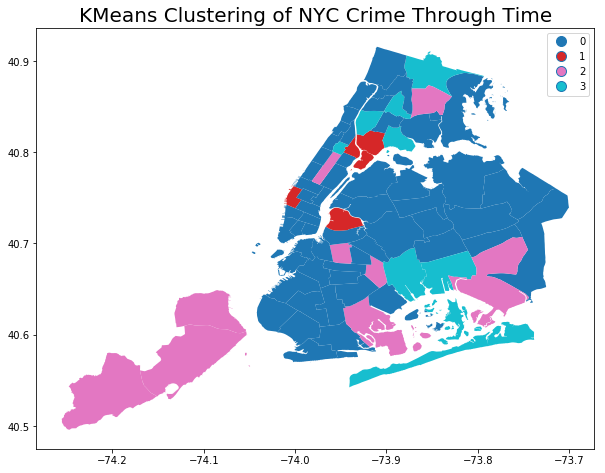

In [642]:
pctshp_crime.plot(column='cluster',figsize=(10,10),categorical=True,legend=True,cmap='tab10')
plt.title("KMeans Clustering of NYC Crime Through Time",fontsize=20)
plt.show()

Figure 5. The 4 clusters of NYC crime by precinct.

To the extent of showing the spatial distribution of crime over time is clustered, the map helps understand how each cluster is distributed. What is immediately noticeable is the prevalence of cluster zero, which showed a gradual decrease in crime. Other than cluster zero, the only geographic clustering that can be seen is cluster two on Staten Island and cluster one in northern Manhattan/Bronx (the trend that increased). The remaining precincts do not appear to be notably geographically clustered.

## 2.3 download the data containing the socioeconomic features to be used as exogenous variables. 


In [643]:
# Definition sourced and adapted from https://github.com/fedhere/PUI2017_fb55/blob/master/HW7_fb55/SQL_query.ipynb

SQL_SOURCE = 'https://fb55.carto.com:443/api/v2/sql?q='

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - output format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    data = urllib.parse.urlencode({'format': format, 'q': query})
    data = data.encode("utf-8")
    try:
        response = urllib.request.urlopen(source, data)
    except urllib.error.HTTPError as e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return response.read()

In [644]:
query = '''
SELECT precinct, green, unemployment, medianincome FROM nycsocioeconomicsbyprecinct 
'''

In [645]:
socioeconomics = pd.read_csv(io.BytesIO(queryCartoDB(query)), sep=',')
socioeconomics.head()

,precinct,green,unemployment,medianincome
0,1,0.058702,0.021444,124092.068749
1,60,0.173512,0.056448,35015.008703
2,61,0.238375,0.055458,65998.923662
3,63,0.158530,0.031215,33655.205265
4,24,0.166040,0.043461,113966.467973


## 2.4 pivot the crime dataframe so that you have a dataframe with precinct on the index and each crime type on the columns 


In [646]:
crimepivot = crime[['PCT','CRIME','crimeMean']].pivot(index='PCT',columns='CRIME')
crimepivot.columns = crimepivot.columns.droplevel(0)
crimepivot = crimepivot.rename(columns={'BURGLARY                              ': 'BURGLARY',
                                  'FELONY ASSAULT                        ': 'FELONY ASSAULT',
                                  'GRAND LARCENY                         ': 'GRAND LARCENY',
        'GRAND LARCENY OF MOTOR VEHICLE                                  ': 'GRAND LARCENY OF MOTOR VEHICLE',
         'MURDER & NON NEGL. MANSLAUGHTER                                ': 'MURDER & NON NEGL. MANSLAUGHTER',
                                  'RAPE                                  ': 'RAPE',
                                  'ROBBERY                               ': 'ROBBERY',
                                       'TOTAL SEVEN MAJOR FELONY OFFENSES': 'TOTAL SEVEN MAJOR FELONY OFFENSES'})
crimepivot.head()

CRIME,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON NEGL. MANSLAUGHTER,RAPE,ROBBERY,TOTAL SEVEN MAJOR FELONY OFFENSES
PCT,,,,,,,,
1,242.176471,104.882353,1406.705882,81.470588,1.058824,8.588235,125.705882,1970.588235
5,152.941176,130.941176,616.823529,45.882353,1.882353,7.529412,147.058824,1103.058824
6,225.588235,114.352941,1183.000000,82.117647,1.294118,9.470588,199.823529,1815.647059
7,108.176471,124.411765,317.352941,74.117647,2.588235,10.705882,172.000000,809.352941
9,247.882353,169.647059,833.176471,89.529412,2.294118,15.470588,208.764706,1566.764706


## 2.5 merge the dataframe with the socioeconomic data with the pivoted crime data,  and merge the precinct geodataframe with it. plot a choropleth of each of the 7 felonies, plus the total crime by precinct

In [647]:
seCrime = socioeconomics.merge(crimepivot,left_on='precinct',right_index=True)

In [648]:
pctshp_seCrime = pctshp.merge(seCrime,on='precinct')
pctshp_seCrime.head()

,precinct,shape_leng,shape_area,geometry,green,unemployment,medianincome,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON NEGL. MANSLAUGHTER,RAPE,ROBBERY,TOTAL SEVEN MAJOR FELONY OFFENSES
0,1.0,80586.154615,4.730176e+07,(POLYGON ((-74.0438776157395 40.69018767637665...,0.058702,0.021444,124092.068749,242.176471,104.882353,1406.705882,81.470588,1.058824,8.588235,125.705882,1970.588235
1,5.0,18676.124259,1.808880e+07,POLYGON ((-73.98863862848766 40.72293372026369...,0.049462,0.046260,99148.860914,152.941176,130.941176,616.823529,45.882353,1.882353,7.529412,147.058824,1103.058824
2,6.0,27182.610113,2.213193e+07,POLYGON ((-73.99968392160721 40.73855224865976...,0.035655,0.029992,119565.099444,225.588235,114.352941,1183.000000,82.117647,1.294118,9.470588,199.823529,1815.647059
3,7.0,17301.308682,1.836402e+07,"POLYGON ((-73.97345389423181 40.718962954076, ...",0.125848,0.052540,44645.989878,108.176471,124.411765,317.352941,74.117647,2.588235,10.705882,172.000000,809.352941
4,9.0,19773.233410,2.139423e+07,POLYGON ((-73.97160900246391 40.72672340116989...,0.080894,0.041264,82391.812180,247.882353,169.647059,833.176471,89.529412,2.294118,15.470588,208.764706,1566.764706


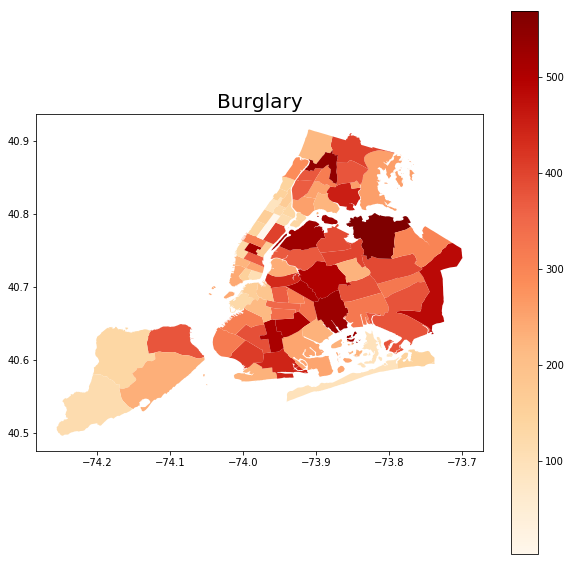

In [649]:
pctshp_seCrime.plot(column='BURGLARY',figsize=(10,10),cmap='OrRd', legend=True)
plt.title("Burglary",fontsize=20)
plt.show()

Figure 6. The number of burglaries per precinct averaged from 2000 to 2016. 

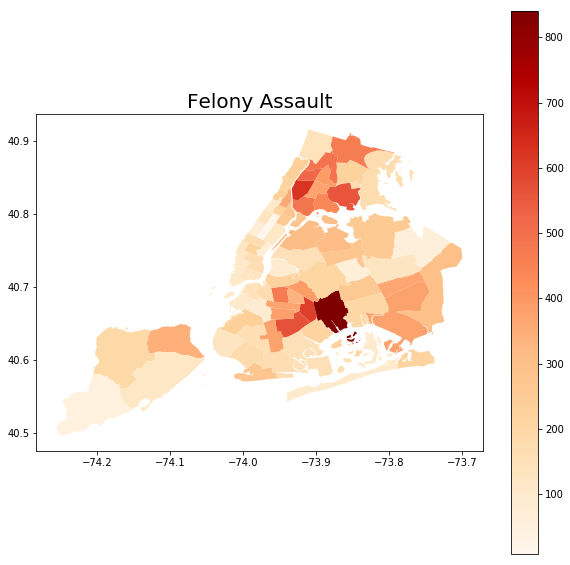

In [650]:
pctshp_seCrime.plot(column='FELONY ASSAULT',figsize=(10,10),cmap='OrRd', legend=True)
plt.title("Felony Assault",fontsize=20)
plt.show()

Figure 7. The number of felony assaults per precinct averaged from 2000 to 2016. 

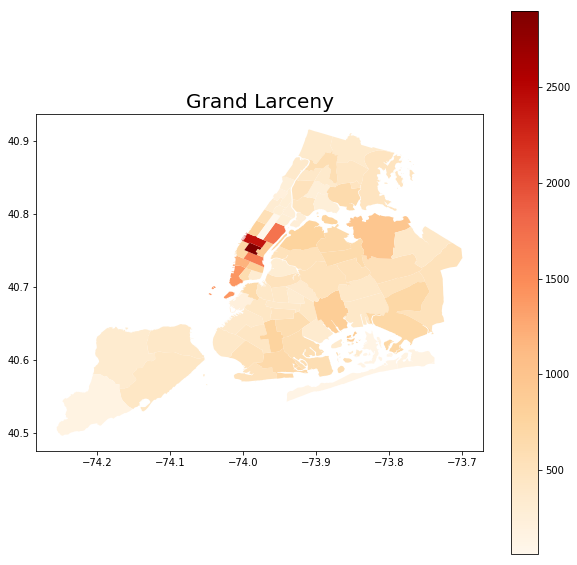

In [651]:
pctshp_seCrime.plot(column='GRAND LARCENY',figsize=(10,10),cmap='OrRd', legend=True)
plt.title("Grand Larceny",fontsize=20)
plt.show()

Figure 8. The number of grand larcenies per precinct averaged from 2000 to 2016. Grand larceny appears particularly centered around midtown Manhattan.

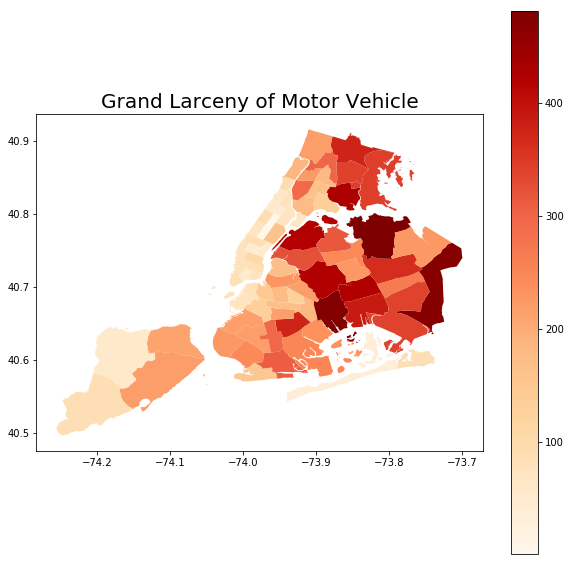

In [652]:
pctshp_seCrime.plot(column='GRAND LARCENY OF MOTOR VEHICLE',figsize=(10,10),cmap='OrRd', legend=True)
plt.title("Grand Larceny of Motor Vehicle",fontsize=20)
plt.show()

Figure 9. The number of grand larcencies of motor vehicles per precinct averaged from 2000 to 2016. Grand larceny of motor vehicles appears to be more prevalent in east Brooklyn and Queens, perhaps due to car ownership. 

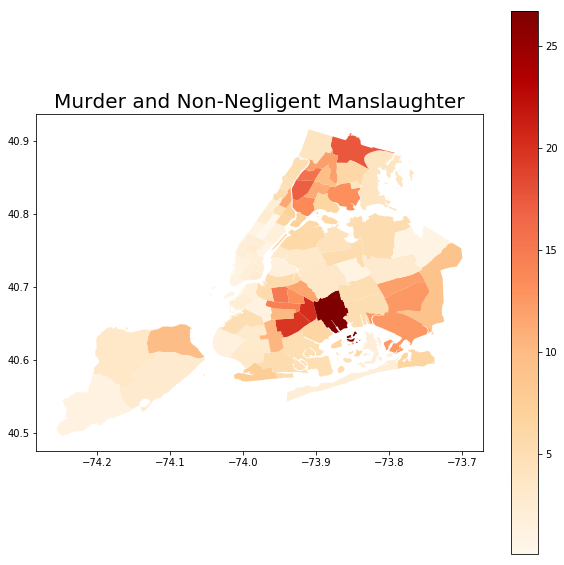

In [653]:
pctshp_seCrime.plot(column='MURDER & NON NEGL. MANSLAUGHTER',figsize=(10,10),cmap='OrRd', legend=True)
plt.title("Murder and Non-Negligent Manslaughter",fontsize=20)
plt.show()

Figure 10. The number of murders and non-negligent manslaughter per precinct averaged from 2000 to 2016. 

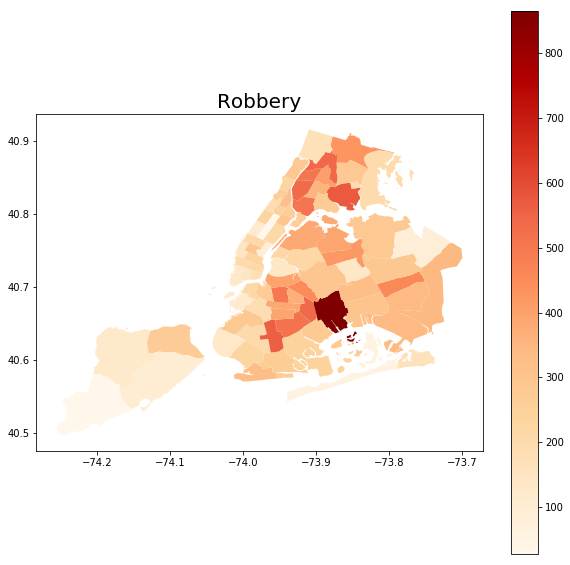

In [654]:
pctshp_seCrime.plot(column='ROBBERY',figsize=(10,10),cmap='OrRd', legend=True)
plt.title("Robbery",fontsize=20)
plt.show()

Figure 11. The number of robberies per precinct averaged from 2000 to 2016. 

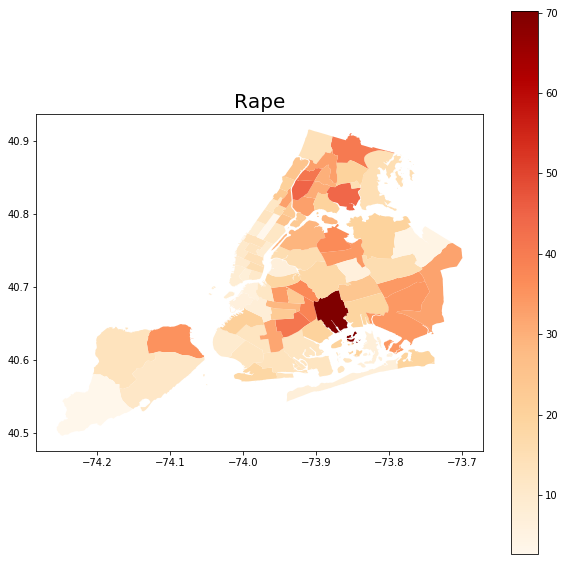

In [655]:
pctshp_seCrime.plot(column='RAPE',figsize=(10,10),cmap='OrRd', legend=True)
plt.title("Rape",fontsize=20)
plt.show()

Figure 12. The number of rapes per precinct averaged from 2000 to 2016. 

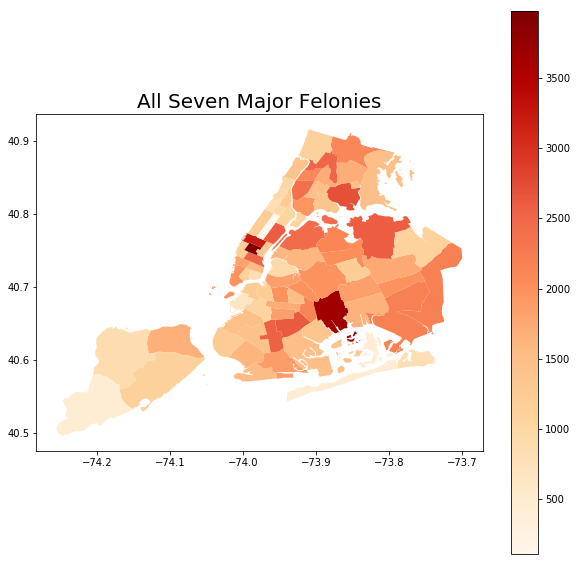

In [656]:
pctshp_seCrime.plot(column='TOTAL SEVEN MAJOR FELONY OFFENSES', figsize=(10,10), cmap='OrRd', legend=True)
plt.title("All Seven Major Felonies", fontsize=20)
plt.show()

Figure 13. The number of all seven major felonies per precinct averaged from 2000 to 2016. 

## 2.6 cluster the data first using the socioeconomic features and then using the 7 felonies 


In [657]:
# setting precinct to index to not preprocess the precinct numbers
se_cluster = socioeconomics.set_index('precinct')
se_cluster.head()

,green,unemployment,medianincome
precinct,,,
1,0.058702,0.021444,124092.068749
60,0.173512,0.056448,35015.008703
61,0.238375,0.055458,65998.923662
63,0.158530,0.031215,33655.205265
24,0.166040,0.043461,113966.467973


In [658]:
se_scaled = preprocessing.scale(se_cluster)
se_scaled.std(axis=0), se_scaled.std(axis=1)

(array([ 1.,  1.,  1.]),
 array([ 1.25269187,  0.45942557,  0.43339713,  0.53962861,  0.80896773,
         0.77026478,  0.4888171 ,  0.76572513,  0.2685816 ,  0.43371498,
         0.82670836,  0.69267006,  1.16082567,  0.96159162,  0.49861156,
         0.46884848,  0.45089514,  0.26492669,  0.67670352,  0.69225606,
         0.73098064,  0.55771455,  0.34633268,  0.59714814,  0.47624694,
         0.11734767,  0.30586524,  0.27699023,  0.24332545,  0.4680987 ,
         0.71457955,  1.3001124 ,  0.51979014,  0.12695328,  0.04502714,
         1.13506487,  0.20855486,  1.2307199 ,  1.11755112,  1.06181978,
         1.12905953,  0.97686649,  1.44122925,  3.68581929,  0.10680334,
         0.58646384,  0.837612  ,  1.05871737,  0.80604225,  0.98864445,
         1.01714216,  0.80215336,  0.82676851,  0.58382   ,  1.1166423 ,
         0.62274402,  1.08917927,  1.05247973,  1.03288241,  0.89176152,
         0.26823026,  0.14356173,  0.31484298,  1.07139245,  0.14639665,
         0.64193041,  0.36

In [659]:
se_scaled2 = preprocessing.scale(se_cluster, axis=1)
se_scaled2.std(axis=0), se_scaled2.std(axis=1)

Nc = 5
se_km = cluster.KMeans(n_clusters=Nc, random_state=123)
se_km.fit(se_scaled)

se_cluster['clusters'] = se_km.labels_
se_cluster.head()

,green,unemployment,medianincome,clusters
precinct,,,,
1,0.058702,0.021444,124092.068749,0
60,0.173512,0.056448,35015.008703,4
61,0.238375,0.055458,65998.923662,4
63,0.158530,0.031215,33655.205265,3
24,0.166040,0.043461,113966.467973,0


In [660]:
pctshp_se = pctshp.merge(se_cluster,left_on='precinct',right_index=True)

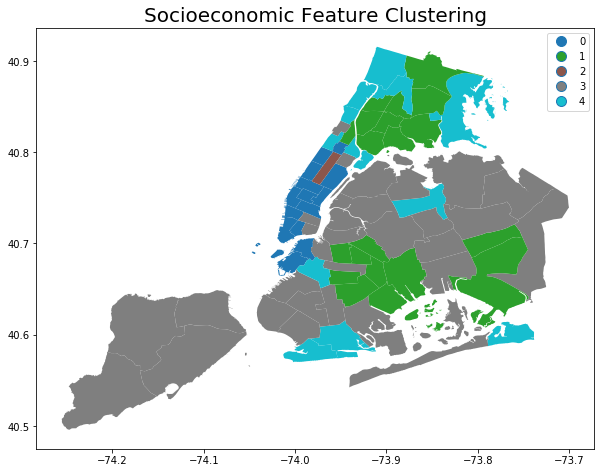

In [661]:
pctshp_se.plot(column='clusters',figsize=(10,10),categorical=True,legend=True,cmap='tab10')
plt.title("Socioeconomic Feature Clustering",fontsize=20)
plt.show()

Figure 14. Five clusters of the socioeconomic features green area, unemployment, and median income by precinct. 

Based on general knowledge of the socioeconomic geographic distribution of NYC, the clustering above makes sense. As Manhattan tends to be a more expensive borough to live in, it would be expected that median income and employment would be higher, thus showing the geographic clustering of cluster number zero. Further, cluster number one seems to be highlighting areas of lower income, in east Brooklyn and the Bronx. Socioeconomic factors, as expected, appear to generally be highly geographically clustered. Central park is an outlier in this map and is cluster two's only precinct. Due to the fact that it is a public park, it's socioeconomics factors cannot be measured in the same way as the rest of the precincts.

In [662]:
crime_scaled = preprocessing.scale(crimepivot)
crime_scaled.std(axis=0), crime_scaled.std(axis=1)

(array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 array([ 0.97411099,  0.37891191,  0.76131124,  0.25669602,  0.42384241,
         0.42312633,  1.07013011,  2.14082619,  0.6444648 ,  1.68963061,
         1.18127698,  0.52452725,  0.38095909,  0.58934479,  0.28863207,
         0.53410521,  0.31579725,  0.41524678,  0.48892419,  0.77844727,
         0.36967367,  0.21488009,  0.7386372 ,  0.55392885,  0.57878292,
         0.57302688,  0.79281653,  0.52608975,  0.73691247,  0.7020667 ,
         0.45783   ,  0.44957696,  0.27756347,  0.53895407,  0.26520161,
         0.59174153,  0.49273321,  0.32768927,  0.43270117,  0.6277411 ,
         0.45615835,  0.25870193,  0.46501354,  0.32891083,  0.18768463,
         0.99950705,  1.13271894,  0.20975063,  0.55839334,  0.25148741,
         0.69029787,  0.56612495,  0.62906908,  0.39440662,  0.24387979,
         0.43248933,  0.30389606,  0.30171827,  0.45110906,  0.62742832,
         0.42686236,  0.82750423,  0.68372651,  0.56476526,  0.66502603,
 

In [663]:
crime_scaled2 = preprocessing.scale(crimepivot, axis=1)
crime_scaled2.std(axis=0), crime_scaled2.std(axis=1)

Nc = 5
crime_km = cluster.KMeans(n_clusters=Nc, random_state=123)
crime_km.fit(crime_scaled)

crimepivot['clusters'] = crime_km.labels_
crimepivot.head()

CRIME,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON NEGL. MANSLAUGHTER,RAPE,ROBBERY,TOTAL SEVEN MAJOR FELONY OFFENSES,clusters
PCT,,,,,,,,,
1,242.176471,104.882353,1406.705882,81.470588,1.058824,8.588235,125.705882,1970.588235,4
5,152.941176,130.941176,616.823529,45.882353,1.882353,7.529412,147.058824,1103.058824,2
6,225.588235,114.352941,1183.000000,82.117647,1.294118,9.470588,199.823529,1815.647059,2
7,108.176471,124.411765,317.352941,74.117647,2.588235,10.705882,172.000000,809.352941,2
9,247.882353,169.647059,833.176471,89.529412,2.294118,15.470588,208.764706,1566.764706,2


In [664]:
pctshp_crime = pctshp.merge(crimepivot,left_on='precinct',right_index=True)

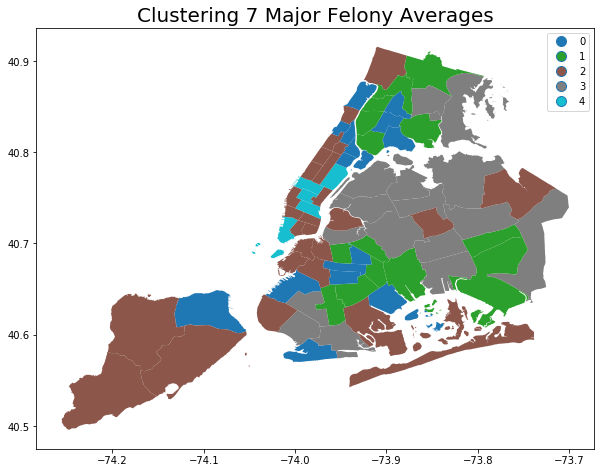

In [665]:
pctshp_crime.plot(column='clusters',figsize=(10,10),categorical=True,legend=True,cmap='tab10')
plt.title("Clustering 7 Major Felony Averages", fontsize=20)
plt.show()

Figure 15. Five clusters of the seven major felonies by precinct. 

As opposed to figure 5 which showed similarities in yearly crime trends, this map shows trends by felony types. Figures 6 through 13 demonstrate that different crime types have a different geographic distribution, such as grand larceny of motor vehicles concentrating in Queens or grand larcenies concentrating in midtown Manhattan. Therefore, figure 15's cluster map illustrates the trends of felony types, showing geographic clustering through Staten Island, parts of Manhattan and Queens. Generally however, the map appears less clustered than figure 14, showing that crime types are not as segregated as socioeconomic factors. There do not appear to be outliers in the clustering. 

## 2.7 Create a function that for a target variable input generates a model based on median income (medianincome), green area (green), and unemployed fraction (unemployment), and returns some parameter of model quality and the most important feature in the model. The function should also print or otherwise report whether the feature is statistically significant. Run this function four times to predict BURGLARY, RAPE, MURDER, and TOTAL CRIME

In [666]:
# Finding max absolute value and pvalue of model coefficients given a model, assuming 3 coefficients
def importance(model):
    coeffs = abs(model.params[1:4])
    pv = model.pvalues
    if max(coeffs.values) == coeffs[0]:
        print("Green Area")
        if pv[0] < 0.05:
            return("This Feature is Statistically Significant")
        else:
            return("This Feature is Not Statistically Significant")
    elif max(coeffs.values) == coeffs[1]:
        print("Unemployment")
        if pv[1] < 0.05:
            return("This Feature is Statistically Significant")
        else:
            return("This Feature is Not Statistically Significant")
    elif max(coeffs.values) == coeffs[2]:
        print("Median Income")
        if pv[2] < 0.05:
            return("This Feature is Statistically Significant")
        else:
            return("This Feature is Not Statistically Significant")

# Generate model from an input dependent variable, output model quality and most important feature
def fitCrime(depVar):
    crimeModel = smf.ols(formula = "depVar ~ seCrime['green'] + seCrime['unemployment'] + seCrime['medianincome']",
                       data = seCrime).fit()
    print('Model Quality: ')
    print(crimeModel.rsquared_adj)
    print('Most Important Feature: ')
    print(importance(crimeModel))

In [667]:
fitCrime(seCrime['BURGLARY'])

Model Quality: 
0.188422312233
Most Important Feature: 
Unemployment
This Feature is Statistically Significant


In [668]:
fitCrime(seCrime['RAPE'])

Model Quality: 
0.497292960905
Most Important Feature: 
Unemployment
This Feature is Statistically Significant


In [669]:
fitCrime(seCrime['MURDER & NON NEGL. MANSLAUGHTER'])

Model Quality: 
0.557309759845
Most Important Feature: 
Unemployment
This Feature is Statistically Significant


In [670]:
fitCrime(seCrime['TOTAL SEVEN MAJOR FELONY OFFENSES'])

Model Quality: 
0.129719250197
Most Important Feature: 
Green Area
This Feature is Statistically Significant


A multivariate regression was chosen to model the data as it would reflect the combinations of independent variables green area, unemployment, and median income on an input dependent variable. The quality of the model is measured through the adjusted R squared, which describes how closely the data fits with the regression. Further the adjusted R squared was chosen to allow direct comparison between different model quality. The most important feature was selected by finding the absolute value of the largest coefficient, which would describe the extent of the effect the variable has on the model. The absolute value of the coefficient was taken because the effect could be positive or negative. 

The results of the 3 crime types and total felonies show that murder is most accurately able to be predicted by green area, unemployment, and median income, with an ajdusted R squared of 0.55, compared with the slightly lower 0.49 for rape and lower still 0.188 and 0.12 for burglary and total felonies. Unemployment is the largest predictor of each crime type except total felonies, which curiously is green area. All of these most important features were found to be statistically significant, as a p-value of under 0.05 was assumed to be suitable to assess significance. 